# <center>Data Mining Project 1 Spring semester 2018-2019</center>
## <center>Παναγιώτης Ευαγγελίου &emsp; 1115201500039</center>
## <center>Ευάγγελος Σπίθας &emsp;&emsp;&emsp;&ensp; 1115201500147</center>

___

### Do all the necessary imports for this notebook

In [1]:
# for wordclouds
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd
from wordcloud import WordCloud
from IPython.display import Image
from PIL import Image as imgWordcloud
import numpy as np

# for preprocessing
import re
from string import punctuation
from nltk.stem import StemmerI, RegexpStemmer, LancasterStemmer, ISRIStemmer, PorterStemmer, SnowballStemmer, RSLPStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords as nltkStopwords

# for classification
from sklearn import svm, preprocessing
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim.models import Word2Vec
import random
from operator import add

## __Data Analysis__

- ### *Wordclouds*

In [2]:
# read train data
trainData = pd.read_csv('../twitter_data/train2017.tsv', sep='\t+', escapechar="\\",
                        engine='python', names=['ID_1', 'ID_2', 'Label', 'Text'])
# trainData = trainData[:5000] # printToBeRemoved

# make stop words
stopWords = ENGLISH_STOP_WORDS

# trainData # printToBeRemoved

  - #### Wordcloud for all tweets

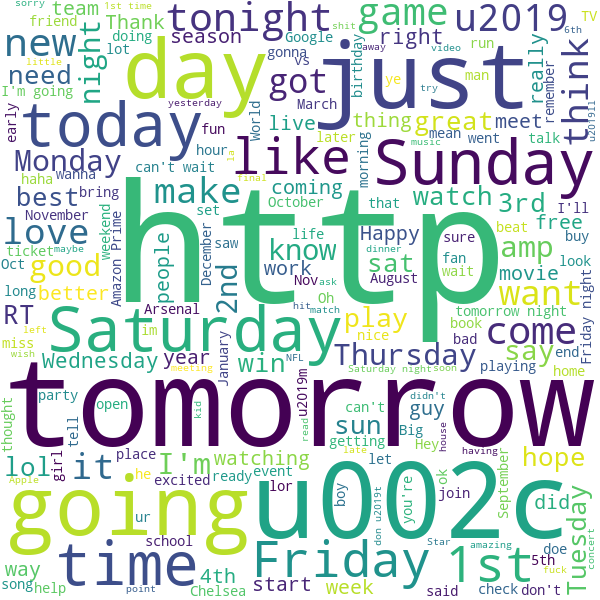

In [3]:
# make a text of all tweets
wholeText = ''
for tweetText in trainData['Text']:
    wholeText = wholeText + ' ' + tweetText

# wholeText # printToBeRemoved

wc = WordCloud(width=600, height=600, background_color='white', stopwords=stopWords)

wc.generate(wholeText)
wc.to_file('wholeTextWordcloud.png')

Image('wholeTextWordcloud.png')

As we see in the above wordcloud there are many useless words like "http" so let's do some preprocessing.

In [4]:
def replaceEmojis(text):
    """
    Turn emojis into smilePositive and smileNegative to reduce noise
    """
    processedText = text.replace('0:-)', 'smilePositive')
    processedText = processedText.replace(':)', 'smilePositive')
    processedText = processedText.replace(':D', 'smilePositive')
    processedText = processedText.replace(':*', 'smilePositive')
    processedText = processedText.replace(':o', 'smilePositive')
    processedText = processedText.replace(':p', 'smilePositive')
    processedText = processedText.replace(';)', 'smilePositive')

    processedText = processedText.replace('>:(', 'smileNegative')
    processedText = processedText.replace(';(', 'smileNegative')
    processedText = processedText.replace('>:)', 'smileNegative')
    processedText = processedText.replace('d:<', 'smileNegative')
    processedText = processedText.replace(':(', 'smileNegative')
    processedText = processedText.replace(':|', 'smileNegative')
    processedText = processedText.replace('>:/', 'smileNegative')

    return processedText


def preprocessText(initText):
    # Replace these characters as we saw in the first wordcloud that are not useful in this form
    processedText = initText.replace("\\u002c", ',')
    processedText = processedText.replace("\\u2019", '\'')

    # Make everything to lower case
    processedText = processedText.lower()

    # Remove urls
    processedText = re.sub(r'(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)'
                           r'*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?', ' ', processedText)

    # Remove hashtags
    processedText = re.sub(r"\B#\w\w+", ' ', processedText)

    # Remove tags
    processedText = re.sub(r"\B@\w\w+", ' ', processedText)

    # Replace emojis with tags
    processedText = replaceEmojis(processedText)

    # Replace hahas
    processedText = re.sub('hahaha+', ' ', processedText)
    processedText = re.sub('haha+', ' ', processedText)

    # Remove any punctuation from the text
    for c in punctuation:
        processedText = processedText.replace(c, ' ')

    # Remove consecutive spaces
    processedText = re.sub(r" {2,}", ' ', processedText)    
    
    # Split to words
    tokens = word_tokenize(processedText)

    filtered = [w for w in tokens if w not in stopWords]

    if not filtered:  # list is empty
        processedText = ''
    else:
        processedText = filtered[0]
        for word in filtered[1:]:
            processedText = processedText + ' ' + word

    return processedText

def stemmingPreprocess(initText):
    # Split to words
    tokens = word_tokenize(initText)

    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in tokens]

    if not stems:  # list is empty
        processedText = ''
    else:
        processedText = stems[0]
        for stem in stems[1:]:
            processedText = processedText + ' ' + stem

    return processedText

In [5]:
# In the first wordcloud we see that there are many words that are not included in stop words
# So let's add our stop words
myAdditionalStopWords = ['tomorrow', 'today', 'day', 'tonight', 'sunday',
                         'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
                         'saturday', 'week', 'just', 'going', 'time']
stopWords = (stopWords.union(myAdditionalStopWords)).union(nltkStopwords.words('english'))

for index, row in trainData.iterrows():
    initialText = row["Text"]
    trainData.loc[index, "Text"] = preprocessText(initialText)

# trainData # printToBeRemoved

Let's make again a wordcloud for the text of all tweets

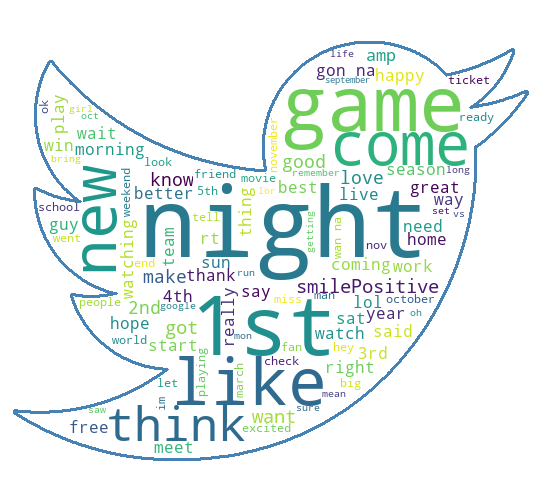

In [6]:
# make a text of all tweets
wholeText = ''
for tweetText in trainData['Text']:
    wholeText = wholeText + ' ' + tweetText

# wholeText # printToBeRemoved

generalMask = np.array(imgWordcloud.open("generalMask.png"))

wc = WordCloud(background_color="white", mask=generalMask, max_words=100,
               stopwords=stopWords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(wholeText)

# store to file
wc.to_file('wholeTextCleanWordcloud.png')

Image('wholeTextCleanWordcloud.png')

#### Make content for each category of all tweets

In [7]:
tweetCategories = list(set(trainData['Label']))

# make a dictionary of form {category:contentString}
contentDict = {category: '' for category in tweetCategories}

# fill the content of each category
for (content, category) in zip(trainData['Text'], trainData['Label']):
    contentDict[category] = contentDict[category] + ' ' + content

# contentDict # printToBeRemoved

  - #### Wordcloud for positive tweets

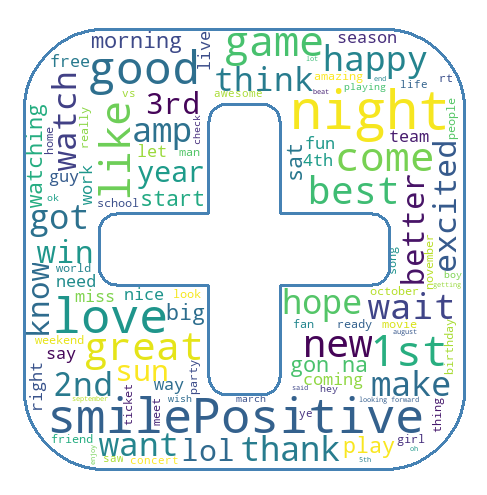

In [8]:
positiveMask = np.array(imgWordcloud.open("positiveMask.png"))

wc = WordCloud(background_color="white", mask=positiveMask, max_words=100,
               stopwords=stopWords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(contentDict['positive'])

# store to file
wc.to_file('positiveWordcloud.png')

Image('positiveWordcloud.png')

  - #### Wordcloud for negative tweets

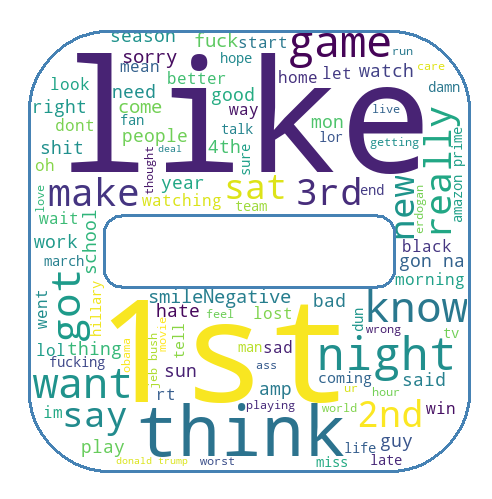

In [9]:
negativeMask = np.array(imgWordcloud.open("negativeMask.png"))

wc = WordCloud(background_color="white", mask=negativeMask, max_words=100,
               stopwords=stopWords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(contentDict['negative'])

# store to file
wc.to_file('negativeWordcloud.png')

Image('negativeWordcloud.png')

  - #### Wordcloud for neutral tweets

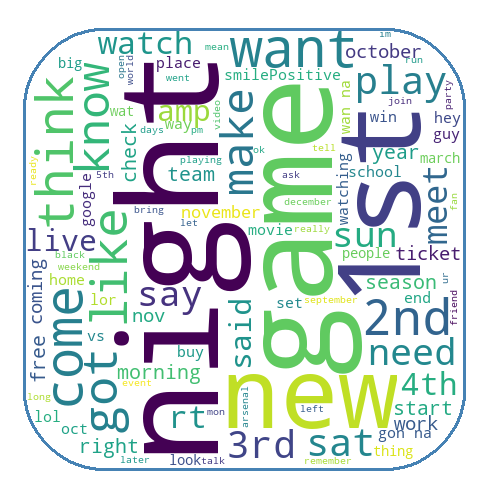

In [10]:
neutralMask = np.array(imgWordcloud.open("neutralMask.png"))

wc = WordCloud(background_color="white", mask=neutralMask, max_words=100,
               stopwords=stopWords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(contentDict['neutral'])

# store to file
wc.to_file('neutralWordcloud.png')

Image('neutralWordcloud.png')

___

## __Classification__

  - #### Classification using SVM classifier

In [11]:
def SvmClassification(trainX, trainY, testX, testY, labelEncoder):
    clf = svm.SVC(kernel='linear')

    # fit train set
    clf.fit(trainX, trainY)

    predY = clf.predict(testX)

    # Classification_report
    print(classification_report(testY, predY, target_names=list(labelEncoder.classes_)))

    return accuracy_score(testY, predY)

  - #### Classification using KNN classifier

In [12]:
def KnnClassification(trainX, trainY, testX, testY, labelEncoder):
    knn = KNeighborsClassifier(n_neighbors=5)

    # fit train set
    knn.fit(trainX, trainY)

    # Predict test set (here is the same as the train set)
    predY = knn.predict(testX)

    # Classification_report
    print(classification_report(testY, predY, target_names=list(labelEncoder.classes_)))

    return accuracy_score(testY, predY)

Prepare train and test data that we will need below

In [13]:
# read test data
testData = pd.read_csv('../twitter_data/test2017.tsv', sep='\t', names=['ID_1', 'ID_2', 'Label', 'Text'])

# preprocess test data
for index, row in testData.iterrows():
    initialText = row["Text"]
    testData.loc[index, "Text"] = preprocessText(initialText)

# read test results
testResults = pd.read_csv('../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt',
                          sep='\t', names=['ID', 'Label'])

# Build label encoder for categories
le = preprocessing.LabelEncoder()
le.fit(trainData["Label"])

# Transform categories into numbers
trainY = le.transform(trainData["Label"])
testY = le.transform(testResults["Label"])

accuracyDict = dict()

# Let's do stemming
for index, row in trainData.iterrows():
    initialText = row["Text"]
    trainData.loc[index, "Text"] = stemmingPreprocess(initialText)

for index, row in testData.iterrows():
    initialText = row["Text"]
    testData.loc[index, "Text"] = stemmingPreprocess(initialText)
    
# trainData # printToBeRemoved

## __Vectorization__

Let's do classification using 3 different ways of vectorization

  - #### Bag-of-words vectorization

In [10]:
bowVectorizer = CountVectorizer(max_features=1000)

trainX = bowVectorizer.fit_transform(trainData['Text'])
testX = bowVectorizer.transform(testData['Text'])

print('-------------SVM Classification Report with BOW Vectorization-------------')
accuracyDict["BOW-SVM"] = SvmClassification(trainX, trainY, testX, testY, le)

print('-------------KNN Classification Report with BOW Vectorization-------------')
accuracyDict["BOW-KNN"] = KnnClassification(trainX, trainY, testX, testY, le)

-------------SVM Classification Report with BOW Vectorization-------------
              precision    recall  f1-score   support

    negative       0.67      0.21      0.32      3972
     neutral       0.55      0.83      0.66      5937
    positive       0.49      0.45      0.47      2375

   micro avg       0.55      0.55      0.55     12284
   macro avg       0.57      0.49      0.48     12284
weighted avg       0.58      0.55      0.51     12284

-------------KNN Classification Report with BOW Vectorization-------------
              precision    recall  f1-score   support

    negative       0.42      0.18      0.25      3972
     neutral       0.52      0.76      0.62      5937
    positive       0.40      0.31      0.35      2375

   micro avg       0.49      0.49      0.49     12284
   macro avg       0.44      0.42      0.41     12284
weighted avg       0.46      0.49      0.45     12284



  - #### Tf-idf vectorization

In [11]:
tfIdfVectorizer = TfidfVectorizer(max_features=1000)

trainX = tfIdfVectorizer.fit_transform(trainData['Text'])
testX = tfIdfVectorizer.transform(testData['Text'])

print('-------------SVM Classification Report with TfIdf Vectorization-------------')
accuracyDict["TfIdf-SVM"] = SvmClassification(trainX, trainY, testX, testY, le)

print('-------------KNN Classification Report with TfIdf Vectorization-------------')
accuracyDict["TfIdf-KNN"] = KnnClassification(trainX, trainY, testX, testY, le)

-------------SVM Classification Report with TfIdf Vectorization-------------
              precision    recall  f1-score   support

    negative       0.67      0.19      0.30      3972
     neutral       0.55      0.82      0.66      5937
    positive       0.48      0.46      0.47      2375

   micro avg       0.55      0.55      0.55     12284
   macro avg       0.56      0.49      0.48     12284
weighted avg       0.57      0.55      0.51     12284

-------------KNN Classification Report with TfIdf Vectorization-------------
              precision    recall  f1-score   support

    negative       0.43      0.19      0.26      3972
     neutral       0.51      0.75      0.61      5937
    positive       0.35      0.27      0.30      2375

   micro avg       0.47      0.47      0.47     12284
   macro avg       0.43      0.40      0.39     12284
weighted avg       0.45      0.47      0.44     12284



  - #### Word embeddings vectorization

Train the word embeddings model and save it. If the model is already trained and saved then you only have to load
it as shown in the next cell

In [16]:
# Word embeddings
tokenize = lambda x: x.split()
tokens = [word_tokenize(row["Text"]) for index, row in trainData.iterrows()]  # tokenizing
# print(tokenized_tweet) # printToBeRemoved
vec_size = 200
model_w2v = gensim.models.Word2Vec(
            tokens,
            size=200,  # desired no. of features/independent variables
            window=5,  # context window size
            min_count=2,
            sg=1,  # 1 for skip-gram model
            hs=0,
            negative=10,  # for negative sampling
            workers=2,  # no.of cores
            seed=34)

model_w2v.train(tokens, total_examples=trainData.shape[0], epochs=20)

model_w2v.save("word2vec.model")

Load the word embeddings model

In [10]:
model_w2v = Word2Vec.load("word2vec.model")

Use the following function to vectorize the data using the word embeddings vectorizer

In [18]:
def sample_floats(low, high, k=1):
    """ Return a k-length list of unique random floats
        in the range of low <= x <= high
    """
    result = []
    seen = set()
    for i in range(k):
        x = random.uniform(low, high)
        while x in seen:
            x = random.uniform(low, high)
        seen.add(x)
        result.append(x)
    return result


def wordEmbeddingsVectorizer(data):
    text_vec = []
    for index, row in data.iterrows():
        text = row["Text"]
        text_len = len(text)
        if text_len == 0:
            tweet_vec = sample_floats(-5.0, 5.0, vec_size)
            text_vec.append(tweet_vec)
            continue
        tokens = word_tokenize(text)
        if tokens[0] in model_w2v.wv.vocab:
            tweet_vec = model_w2v.wv[tokens[0]]
        else:
            tweet_vec = sample_floats(-5.0, 5.0, vec_size)
        for token in tokens[1:]:
            if token in model_w2v.wv.vocab:
                tweet_vec = list(map(add, tweet_vec, model_w2v.wv[token]))
            else:
                tweet_vec = list(map(add, tweet_vec, sample_floats(-5.0, 5.0, vec_size)))
        final_tweet_vec = [i / text_len for i in tweet_vec]
        text_vec.append(final_tweet_vec)

    return np.array(text_vec)

In [19]:
trainX = wordEmbeddingsVectorizer(trainData)
testX = wordEmbeddingsVectorizer(testData)

print('-------------SVM Classification Report with Word Embeddings Vectorization-------------')
accuracyDict["WordEmbed-SVM"] = SvmClassification(trainX, trainY, testX, testY, le)

print('-------------KNN Classification Report with Word Embeddings Vectorization-------------')
accuracyDict["WordEmbed-KNN"] = KnnClassification(trainX, trainY, testX, testY, le)

-------------SVM Classification Report with Word Embeddings Vectorization-------------


/home/panos/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      3972
     neutral       0.49      0.51      0.50      5937
    positive       0.20      0.52      0.29      2375

   micro avg       0.35      0.35      0.35     12284
   macro avg       0.23      0.34      0.26     12284
weighted avg       0.27      0.35      0.30     12284

-------------KNN Classification Report with TfIdf Vectorization-------------
              precision    recall  f1-score   support

    negative       0.35      0.17      0.23      3972
     neutral       0.49      0.52      0.50      5937
    positive       0.20      0.35      0.25      2375

   micro avg       0.37      0.37      0.37     12284
   macro avg       0.35      0.34      0.33     12284
weighted avg       0.39      0.37      0.37     12284



## __Final Results__

In [12]:
accuracyDict["WordEmbed-KNN"] = 1.0 # to be removed
accuracyDict["WordEmbed-SVM"] = 1.0 # to be removed
resultsData = {r'Vectorizer \ Classifier': ['BOW', 'Tfidf', 'Word Embeddings'],
               'KNN': [accuracyDict["BOW-KNN"], accuracyDict["TfIdf-KNN"], accuracyDict["WordEmbed-KNN"]],
               'SVM': [accuracyDict["BOW-SVM"], accuracyDict["TfIdf-SVM"], accuracyDict["WordEmbed-SVM"]]}

resultsDataFrame = pd.DataFrame(data=resultsData)

resultsDataFrame

,Vectorizer \ Classifier,KNN,SVM
0,BOW,0.485754,0.552507
1,Tfidf,0.474031,0.546646
2,Word Embeddings,1.000000,1.000000
